In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import typing
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import Descriptors
from typing import Union, List, Tuple
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors3D
from rdkit.Chem import GraphDescriptors
from tqdm import tqdm

RDKit WARNING: [11:16:29] Enabling RDKit 2019.09.1 jupyter extensions
[11:16:29] Enabling RDKit 2019.09.1 jupyter extensions


In [2]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.neural_network import MLPRegressor
from sklearn.inspection import permutation_importance

In [3]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error
from sklearn.utils import resample

In [4]:
import statistics as s

### Helper functions

In [5]:
def find_pattern_count(molecule: Chem.Mol, pattern: Chem.Mol) -> int:
    result = molecule.GetSubstructMatches(pattern)
    return len(result)

def drawSmils(smils: str):
    smilsChromoChem = Chem.MolFromSmiles(smils)
    drawing = Draw.MolToMPL(smilsChromoChem, size=(450,450))


# Read data

In [6]:
qm9_database = pd.read_csv("qm9.csv")
qm9_database["RDKit_Mol_Class"] = qm9_database["smiles"].apply(Chem.MolFromSmiles)
only_solids = pd.read_json("only_solids_features.json").reset_index(drop=True)
only_solids_conf = pd.read_json("only_solids_conf_features.json").reset_index(drop=True)
only_solids["RDKit_Mol_Class"] = only_solids["Chromophore"].apply(Chem.MolFromSmiles)
only_solids_conf["RDKit_Mol_Class"] = only_solids_conf["Chromophore"].apply(Chem.MolFromSmiles)

In [7]:
first_4_cols = ["Chromophore", 'qm9_pattern_indexes', 'RDKit_Mol_Class', "Emission max (nm)"]
only_solids = pd.concat([only_solids[first_4_cols], only_solids.drop(columns=first_4_cols)], axis=1)
only_solids_conf = pd.concat([only_solids_conf[first_4_cols], only_solids_conf.drop(columns=first_4_cols)], axis=1)

In [8]:
only_solids = only_solids_conf

In [9]:
descriptors_names = [ x[0] for x in Descriptors._descList ]
len(descriptors_names)

200

In [10]:
scaler = StandardScaler()
scaler.fit(only_solids[descriptors_names])
only_solids = pd.concat([only_solids[only_solids.columns.drop(descriptors_names)].reset_index(drop=True), pd.DataFrame(scaler.transform(only_solids[descriptors_names]), columns=descriptors_names)], axis=1)

In [11]:
only_solids.drop(only_solids.std()[only_solids.std()==0].index, axis=1, inplace=True)
only_solids.shape

/tmp/ipykernel_3551/88905139.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  only_solids.drop(only_solids.std()[only_solids.std()==0].index, axis=1, inplace=True)


(558, 1127)

In [12]:
nans_cols = only_solids.columns[only_solids.isna().any()]
nans_cols

Index(['Emission max (nm)'], dtype='object')

In [13]:
only_solids.dropna(subset=nans_cols, axis=0, inplace=True)
only_solids.shape

(523, 1127)

In [14]:
universal_features = list(only_solids.columns)[4:]
universal_features_conf = list(only_solids_conf.columns)[4:]

In [15]:
model_data_conf_x = only_solids[universal_features]
model_data_conf_y = only_solids["Emission max (nm)"]

In [16]:
all_quantum_features = list(qm9_database.columns.drop(["RDKit_Mol_Class", "mol_id", "smiles"]))

In [17]:
imp_scores = {}

# Model 1

In [18]:
rfr1 = RandomForestRegressor(random_state=0)

linear_model = LinearRegression()

reg = GradientBoostingRegressor(random_state=0)

In [19]:
rfr1 = RandomForestRegressor(
    max_depth=10,
#                                 max_features=300,
                                min_samples_leaf=20,
                                n_estimators=400
)

linear_model = LinearRegression()

reg = GradientBoostingRegressor(
    learning_rate=0.05,
                                max_depth=4,
#                                 max_features=300,
#                                 min_samples_leaf=20,
                                n_estimators=1000,
    random_state=0
)

In [20]:
lin_model1_features = list(set(model_data_conf_x.columns) & set(descriptors_names))

In [21]:
maes = []
most_imp_feat = pd.DataFrame()
for _ in tqdm(range(100)):
    res_x, res_y = resample(model_data_conf_x, model_data_conf_y)
    oob_idx = set(model_data_conf_y.index).difference(set(res_x.index))
    reg.fit(res_x, res_y)
    x_test, y_test = model_data_conf_x.loc[list(oob_idx),:], model_data_conf_y.loc[list(oob_idx)]
    r = permutation_importance(reg, x_test, y_test,
                            n_repeats=5,
                            random_state=0)
    mif = [[], []]
    for i in r.importances_mean.argsort()[::-1]:
        if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
#         if r.importances_mean[i] - r.importances_std[i] > 0:
#         if r.importances_mean[i] > 0:
            mif[0].append(f"{res_x.columns[i]}")
            mif[1].append(r.importances_mean[i])
    most_imp_feat = pd.concat([most_imp_feat, pd.Series(mif[1], index=mif[0])], axis=1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [2:22:28<00:00, 85.48s/it]


In [22]:
most_ranked = most_imp_feat.dropna()
most_imp_feat.fillna(0, inplace=True)
most_imp_feat.columns = range(most_imp_feat.shape[1])

In [23]:
imp_scores["model1"] = {"most_ranked": most_ranked,
                       "most_imp_feat": most_imp_feat.to_dict()}

In [24]:
most_ranked

,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
MACCS_key99,0.179703,0.138641,0.278944,0.326137,0.326089,0.265135,0.279541,0.160897,0.209571,0.171044,...,0.072797,0.348558,0.307068,0.111021,0.210798,0.300905,0.157792,0.260162,0.243647,0.101878


In [25]:
most_imp_feat["max"] = most_imp_feat.apply(max, axis=1)
most_imp_feat["mean"] = most_imp_feat.apply(np.mean, axis=1)

In [26]:
mst = most_imp_feat.sort_values(by="mean", ascending=False).head(150).index
most_imp_feat.sort_values(by="mean", ascending=False).head(20)

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,max,mean
MACCS_key99,0.179703,0.138641,0.278944,0.326137,0.326089,0.265135,0.279541,0.160897,0.209571,0.171044,...,0.307068,0.111021,0.210798,0.300905,0.157792,0.260162,0.243647,0.101878,0.424114,0.240515
TPSA,0.049671,0.026245,0.000000,0.048697,0.022749,0.018884,0.052765,0.015055,0.016993,0.056004,...,0.066679,0.048313,0.131437,0.000000,0.060837,0.113623,0.060191,0.031845,0.166833,0.051473
VSA_EState2,0.026610,0.000000,0.038744,0.041729,0.102871,0.076086,0.088122,0.032210,0.021440,0.040109,...,0.025646,0.000000,0.027323,0.047490,0.036047,0.049981,0.051972,0.028736,0.102871,0.045225
MorganFP_bit_960,0.044964,0.050857,0.041908,0.018330,0.030352,0.015358,0.010924,0.017030,0.010340,0.047074,...,0.030484,0.044701,0.009546,0.012727,0.008896,0.023875,0.012203,0.054305,0.080253,0.025007
BCUT2D_MRHI,0.026011,0.000000,0.000000,0.023592,0.026511,0.000000,0.051729,0.024566,0.038679,0.011372,...,0.024725,0.009080,0.014328,0.000000,0.024912,0.017577,0.023244,0.012068,0.070045,0.019498
NumAromaticHeterocycles,0.000000,0.000000,0.000000,0.006131,0.000000,0.017118,0.026473,0.046104,0.000000,0.000000,...,0.015633,0.016623,0.023923,0.005980,0.000000,0.000000,0.018421,0.016268,0.058369,0.012423
qed,0.007904,0.010899,0.000000,0.010843,0.012580,0.022854,0.000000,0.000000,0.048729,0.017126,...,0.000000,0.000000,0.018014,0.000000,0.008538,0.000000,0.009085,0.027236,0.075888,0.010865
SlogP_VSA10,0.017335,0.001541,0.000000,0.017533,0.006315,0.001821,0.000000,0.000000,0.021551,0.019662,...,0.016222,0.005029,0.001283,0.020499,0.000000,0.000000,0.022414,0.000097,0.056345,0.010501
BCUT2D_CHGHI,0.000000,0.006857,0.000000,0.020986,0.018954,0.000000,0.003523,0.000000,0.004611,0.000000,...,0.000000,0.006372,0.003830,0.000000,0.006396,0.038839,0.000000,0.009197,0.090934,0.009229
MaxAbsEStateIndex,0.015116,0.030864,0.000000,0.010584,0.000000,0.008192,0.000000,0.000000,0.022862,0.004027,...,0.005003,0.026475,0.000000,0.000000,0.000000,0.019907,0.000000,0.000000,0.075483,0.008383


In [27]:
most_imp_feat

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,max,mean
MACCS_key99,0.179703,0.138641,0.278944,0.326137,0.326089,0.265135,0.279541,0.160897,0.209571,0.171044,...,3.070683e-01,0.111021,0.210798,0.300905,0.157792,0.260162,0.243647,0.101878,4.241138e-01,2.405152e-01
TPSA,0.049671,0.026245,0.000000,0.048697,0.022749,0.018884,0.052765,0.015055,0.016993,0.056004,...,6.667945e-02,0.048313,0.131437,0.000000,0.060837,0.113623,0.060191,0.031845,1.668331e-01,5.147290e-02
MorganFP_bit_960,0.044964,0.050857,0.041908,0.018330,0.030352,0.015358,0.010924,0.017030,0.010340,0.047074,...,3.048426e-02,0.044701,0.009546,0.012727,0.008896,0.023875,0.012203,0.054305,8.025337e-02,2.500691e-02
VSA_EState2,0.026610,0.000000,0.038744,0.041729,0.102871,0.076086,0.088122,0.032210,0.021440,0.040109,...,2.564594e-02,0.000000,0.027323,0.047490,0.036047,0.049981,0.051972,0.028736,1.028709e-01,4.522477e-02
BCUT2D_MRHI,0.026011,0.000000,0.000000,0.023592,0.026511,0.000000,0.051729,0.024566,0.038679,0.011372,...,2.472549e-02,0.009080,0.014328,0.000000,0.024912,0.017577,0.023244,0.012068,7.004509e-02,1.949805e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MorganFP_bit_527,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.222896e-08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.222896e-08,1.034237e-09
MorganFP_bit_535,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000099,0.000000,0.000000,0.000000,0.000000,0.000000,9.872238e-05,1.954899e-06
MorganFP_bit_47,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000036,0.000000,0.000000,0.000000,3.566111e-05,7.061605e-07
MorganFP_bit_621,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000020,0.000000,0.000000,0.000000,2.032000e-05,4.023763e-07


In [28]:
sm = most_imp_feat.iloc[:,-1].sum()

In [29]:
most_imp_feat["percent"] = most_imp_feat["mean"]/sm

In [30]:
most_imp_feat["percent"][:10]*100

MACCS_key99          38.345364
TPSA                  8.206329
MorganFP_bit_960      3.986854
VSA_EState2           7.210189
BCUT2D_MRHI           3.108575
SlogP_VSA10           1.674112
Kappa2                0.210909
MaxAbsEStateIndex     1.336449
fr_bicyclic           1.201154
MaxEStateIndex        1.186261
Name: percent, dtype: float64

In [31]:
mst = most_imp_feat[(most_imp_feat["mean"] > 0.0001)].index
len(mst)

225

In [32]:
mst = most_imp_feat.sort_values(by="mean", ascending=False).head(150).index

In [33]:
model_data_conf_x = only_solids[list(mst)]
model_data_conf_y = only_solids["Emission max (nm)"]

In [34]:
error = []
for _ in tqdm(range(1000)):
    res_x, res_y = resample(model_data_conf_x, model_data_conf_y)
    oob_idx = set(model_data_conf_y.index).difference(set(res_x.index))
    reg.fit(res_x, res_y)
    oob_pred = reg.predict(model_data_conf_x.loc[list(oob_idx),:])
    error.append(model_data_conf_y.loc[list(oob_idx)] - oob_pred)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [2:02:02<00:00,  7.32s/it]


In [35]:
import itertools
errors = np.array(list(itertools.chain.from_iterable(error)))

In [36]:
imp_scores["model1"]["errors"] = list(errors)

<AxesSubplot:ylabel='Count'>

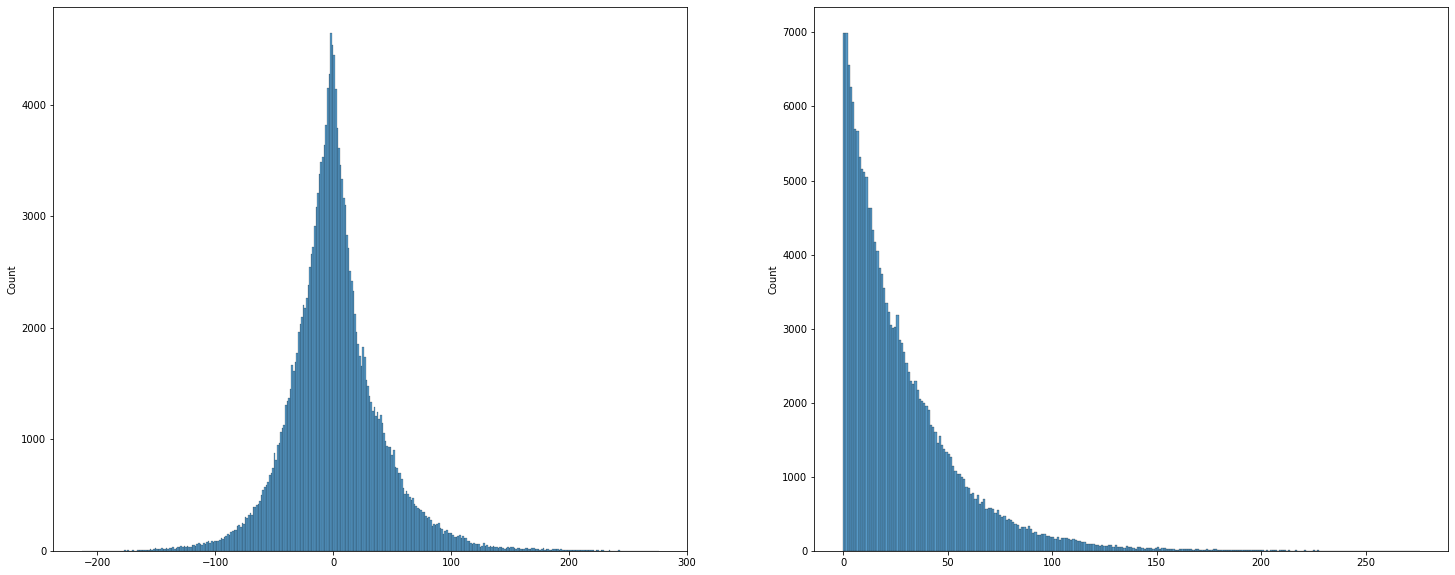

In [37]:
fig, ax = plt.subplots(1,2, figsize=(25, 10))
sns.histplot(errors, ax=ax[0])
sns.histplot(np.abs(errors), ax=ax[1])

In [38]:
s.stdev(errors)

39.17721590852387

In [39]:
np.percentile(errors, 5), np.percentile(errors, 95)

(-58.193103083538844, 68.22125874811023)

In [40]:
abserrors = np.abs(errors)
np.percentile(abserrors, 5), np.percentile(abserrors, 95)

(1.4564330090997544, 81.87485696537072)

In [41]:
np.median(abserrors), np.mean(abserrors)

(19.745995561872405, 27.946062730960342)

# Model 2

In [42]:
def get_features(row, database: pd.DataFrame, features: Union[List[str], str]) -> None:
    for index in row["qm9_pattern_indexes"]:
        count = find_pattern_count(row["RDKit_Mol_Class"], database["RDKit_Mol_Class"][index])
        for feature in features:
            value = count*database[feature][index]
            row[feature] += value
    return row

In [43]:
features = all_quantum_features

In [44]:
only_solids[features] = 0

In [45]:
only_solids = only_solids.apply(get_features, database=qm9_database, features=features, axis=1)

In [46]:
model_data_conf_x = only_solids[universal_features+features]
model_data_conf_y = only_solids["Emission max (nm)"]

In [47]:
linear_model2 = LinearRegression()

In [48]:
lin_model1_features = list(set(model_data_conf_x.columns) & set(descriptors_names))

In [49]:
maes = []
most_imp_feat = pd.DataFrame()
for _ in tqdm(range(100)):
    res_x, res_y = resample(model_data_conf_x, model_data_conf_y)
    oob_idx = set(model_data_conf_y.index).difference(set(res_x.index))
    reg.fit(res_x, res_y)
    x_test, y_test = model_data_conf_x.loc[list(oob_idx),:], model_data_conf_y.loc[list(oob_idx)]
    r = permutation_importance(reg, x_test, y_test,
                            n_repeats=5,
                            random_state=0)
    mif = [[], []]
    for i in r.importances_mean.argsort()[::-1]:
        if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
#         if r.importances_mean[i] - r.importances_std[i] > 0:
#         if r.importances_mean[i] > 0:
            mif[0].append(f"{res_x.columns[i]}")
            mif[1].append(r.importances_mean[i])
    most_imp_feat = pd.concat([most_imp_feat, pd.Series(mif[1], index=mif[0])], axis=1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [2:25:26<00:00, 87.27s/it]


In [50]:
most_ranked = most_imp_feat.dropna()
most_imp_feat.fillna(0, inplace=True)
most_imp_feat.columns = range(most_imp_feat.shape[1])

In [51]:
imp_scores["model2"] = {"most_ranked": most_ranked,
                       "most_imp_feat": most_imp_feat.to_dict()}

In [52]:
most_ranked

,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
MACCS_key99,0.20335,0.263514,0.133767,0.148118,0.259004,0.182429,0.358578,0.20266,0.207568,0.261608,...,0.287571,0.159364,0.147887,0.126998,0.179063,0.075098,0.265973,0.343522,0.087973,0.117339


In [53]:
most_imp_feat["max"] = most_imp_feat.apply(max, axis=1)
most_imp_feat["mean"] = most_imp_feat.apply(np.mean, axis=1)

In [54]:
mst = most_imp_feat.sort_values(by="mean", ascending=False).head(150).index
most_imp_feat.sort_values(by="mean", ascending=False).head(20)

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,max,mean
MACCS_key99,0.203350,0.263514,0.133767,0.148118,0.259004,0.182429,0.358578,0.202660,0.207568,0.261608,...,0.147887,0.126998,0.179063,0.075098,0.265973,0.343522,0.087973,0.117339,0.437629,0.223714
TPSA,0.044840,0.004457,0.016052,0.031738,0.000000,0.027248,0.039378,0.105808,0.035515,0.080623,...,0.011538,0.074399,0.057565,0.101700,0.000000,0.052625,0.010462,0.078729,0.135545,0.053548
VSA_EState2,0.028163,0.065319,0.000000,0.048518,0.026680,0.037292,0.034280,0.040440,0.060039,0.073948,...,0.031514,0.000000,0.027335,0.048474,0.045550,0.037795,0.018919,0.042155,0.130116,0.042744
MorganFP_bit_960,0.019975,0.023805,0.051620,0.037675,0.029851,0.005960,0.025928,0.000000,0.013022,0.021431,...,0.036929,0.038013,0.019274,0.049184,0.057393,0.026503,0.022827,0.018139,0.068933,0.024057
BCUT2D_MRHI,0.025491,0.010044,0.019149,0.029831,0.030662,0.013914,0.016118,0.000000,0.021550,0.051742,...,0.022641,0.019570,0.013515,0.000000,0.018001,0.016449,0.026728,0.018943,0.051742,0.018245
qed,0.049683,0.000000,0.004930,0.012795,0.005830,0.025907,0.026329,0.000000,0.008694,0.039928,...,0.029860,0.076836,0.000000,0.033377,0.000000,0.000000,0.014710,0.008914,0.076836,0.014587
NumAromaticHeterocycles,0.008313,0.007955,0.006174,0.005827,0.004959,0.007469,0.000000,0.021057,0.011767,0.003911,...,0.000000,0.022914,0.010466,0.047621,0.049500,0.000000,0.007815,0.007137,0.049500,0.011133
SlogP_VSA10,0.039083,0.004373,0.009802,0.000000,0.035163,0.015095,0.059699,0.000000,0.026879,0.006951,...,0.009845,0.000000,0.000000,0.000000,0.018305,0.013075,0.000000,0.053124,0.059699,0.010645
MaxAbsEStateIndex,0.010929,0.029058,0.014552,0.016872,0.062924,0.042590,0.000000,0.000000,0.017243,0.018021,...,0.000000,0.027831,0.000000,0.002814,0.000000,0.000000,0.000000,0.025865,0.062924,0.010400
MACCS_key75,0.000000,0.007596,0.005250,0.004266,0.004075,0.001787,0.004156,0.028357,0.022561,0.007360,...,0.023376,0.046371,0.000000,0.002117,0.000000,0.000000,0.019311,0.010421,0.064844,0.008932


In [55]:
most_imp_feat

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,max,mean
MACCS_key99,0.203350,0.263514,0.133767,0.148118,0.259004,0.182429,0.358578,0.202660,0.207568,0.261608,...,0.147887,0.126998,1.790625e-01,0.075098,0.265973,0.343522,0.087973,0.117339,4.376287e-01,2.237143e-01
qed,0.049683,0.000000,0.004930,0.012795,0.005830,0.025907,0.026329,0.000000,0.008694,0.039928,...,0.029860,0.076836,0.000000e+00,0.033377,0.000000,0.000000,0.014710,0.008914,7.683563e-02,1.458719e-02
TPSA,0.044840,0.004457,0.016052,0.031738,0.000000,0.027248,0.039378,0.105808,0.035515,0.080623,...,0.011538,0.074399,5.756515e-02,0.101700,0.000000,0.052625,0.010462,0.078729,1.355448e-01,5.354768e-02
SlogP_VSA10,0.039083,0.004373,0.009802,0.000000,0.035163,0.015095,0.059699,0.000000,0.026879,0.006951,...,0.009845,0.000000,0.000000e+00,0.000000,0.018305,0.013075,0.000000,0.053124,5.969852e-02,1.064476e-02
VSA_EState2,0.028163,0.065319,0.000000,0.048518,0.026680,0.037292,0.034280,0.040440,0.060039,0.073948,...,0.031514,0.000000,2.733512e-02,0.048474,0.045550,0.037795,0.018919,0.042155,1.301158e-01,4.274436e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MorganFP_bit_928,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000082,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,8.172489e-05,1.618315e-06
MorganFP_bit_820,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.154723e-08,0.000000,0.000000,0.000000,0.000000,0.000000,1.154723e-08,2.286581e-10
MorganFP_bit_877,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000e+00,0.000006,0.000000,0.000000,0.000000,0.000000,5.534512e-06,1.095943e-07
MorganFP_bit_164,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000e+00,0.000004,0.000000,0.000000,0.000000,0.000000,4.205894e-06,8.328502e-08


In [56]:
sm = most_imp_feat.iloc[:,-1].sum()

In [57]:
most_imp_feat["percent"] = most_imp_feat["mean"]/sm

In [58]:
most_imp_feat["percent"][:10]*100

MACCS_key99          36.921528
qed                   2.407452
TPSA                  8.837442
SlogP_VSA10           1.756798
VSA_EState2           7.054475
BCUT2D_MRHI           3.011090
NumHeteroatoms        0.185015
MorganFP_bit_960      3.970414
MorganFP_bit_160      0.759961
MaxAbsEStateIndex     1.716465
Name: percent, dtype: float64

In [59]:
mst = most_imp_feat[(most_imp_feat["mean"] > 0.0001)].index
len(mst)

239

In [60]:
mst = most_imp_feat.sort_values(by="mean", ascending=False).head(150).index

In [61]:
model_data_conf_x = only_solids[list(mst)]
model_data_conf_y = only_solids["Emission max (nm)"]

In [62]:
error = []
for _ in tqdm(range(1000)):
    res_x, res_y = resample(model_data_conf_x, model_data_conf_y)
    oob_idx = set(model_data_conf_y.index).difference(set(res_x.index))
    reg.fit(res_x, res_y)
    oob_pred = reg.predict(model_data_conf_x.loc[list(oob_idx),:])
    error.append(model_data_conf_y.loc[list(oob_idx)] - oob_pred)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [2:07:06<00:00,  7.63s/it]


In [63]:
import itertools
errors = np.array(list(itertools.chain.from_iterable(error)))

In [64]:
imp_scores["model2"]["errors"] = list(errors)

<AxesSubplot:ylabel='Count'>

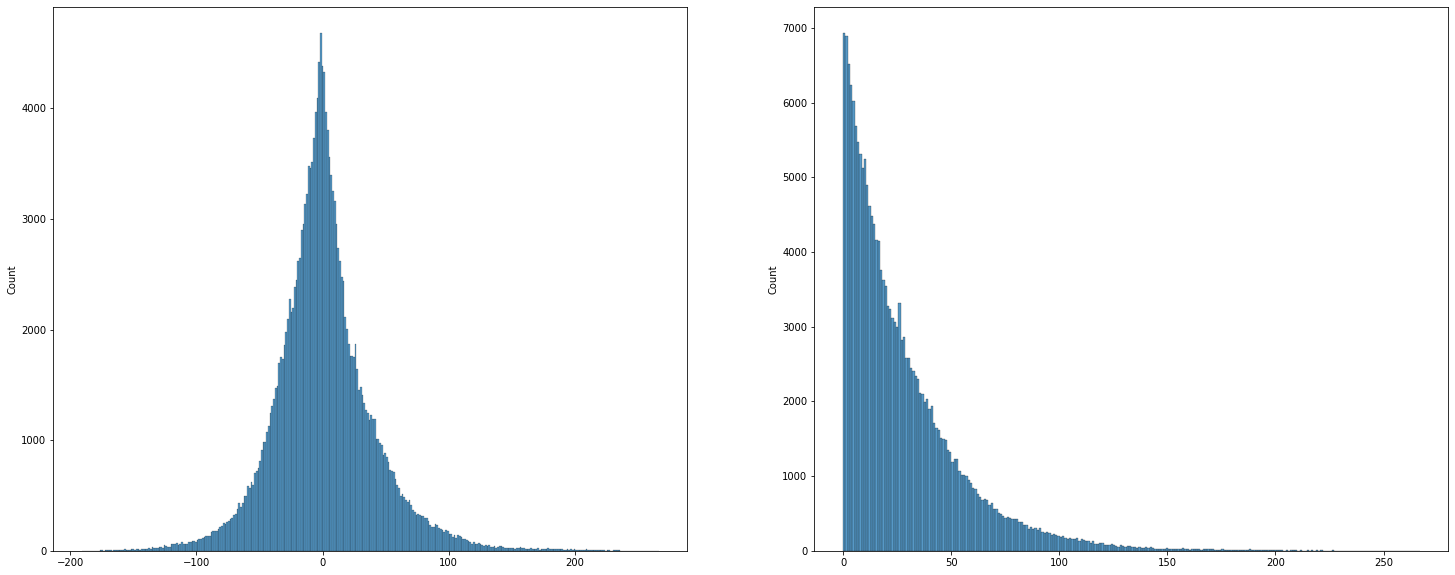

In [65]:
fig, ax = plt.subplots(1,2, figsize=(25, 10))
sns.histplot(errors, ax=ax[0])
sns.histplot(np.abs(errors), ax=ax[1])

In [66]:
s.stdev(errors)

39.25628435527418

In [67]:
np.percentile(errors, 5), np.percentile(errors, 95)

(-58.27727949386292, 68.47229996638093)

In [68]:
abserrors = np.abs(errors)
np.percentile(abserrors, 5), np.percentile(abserrors, 95)

(1.4668624156327836, 82.4941832338687)

In [69]:
np.median(abserrors), np.mean(abserrors)

(19.94735870258026, 28.04581343036717)

# Model 3

In [70]:
def get_features(row, database: pd.DataFrame, features: Union[List[str], str]) -> None:
    for index in row["qm9_pattern_indexes"]:
        count = find_pattern_count(row["RDKit_Mol_Class"], database["RDKit_Mol_Class"][index])
        for feature in features:
            value = database[feature][index]*count
            row[feature] += value
    return row

In [71]:
features = all_quantum_features

In [72]:
only_solids[features] = 0

In [73]:
only_solids = only_solids.apply(get_features, database=qm9_database, features=features, axis=1)

In [74]:
model_data_conf_x = only_solids[features]
model_data_conf_y = only_solids["Emission max (nm)"]

In [75]:
maes = []
most_imp_feat = pd.DataFrame()
for _ in tqdm(range(100)):
    res_x, res_y = resample(model_data_conf_x, model_data_conf_y)
    oob_idx = set(model_data_conf_y.index).difference(set(res_x.index))
    reg.fit(res_x, res_y)
    x_test, y_test = model_data_conf_x.loc[list(oob_idx),:], model_data_conf_y.loc[list(oob_idx)]
    r = permutation_importance(reg, x_test, y_test,
                            n_repeats=5,
                            )
    mif = [[], []]
    for i in r.importances_mean.argsort()[::-1]:
        if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
#         if r.importances_mean[i] - r.importances_std[i] > 0:
#         if r.importances_mean[i] > 0:
            mif[0].append(f"{res_x.columns[i]}")
            mif[1].append(r.importances_mean[i])
    most_imp_feat = pd.concat([most_imp_feat, pd.Series(mif[1], index=mif[0])], axis=1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:48<00:00,  2.89s/it]


In [76]:
most_ranked = most_imp_feat.dropna()
most_imp_feat.fillna(0, inplace=True)
most_imp_feat.columns = range(most_imp_feat.shape[1])

In [77]:
imp_scores["model3"] = {"most_ranked": most_ranked,
                       "most_imp_feat": most_imp_feat.to_dict()}

In [78]:
most_ranked.index.to_list()

['A']

In [79]:
most_imp_feat["max"] = most_imp_feat.apply(max, axis=1)
most_imp_feat["mean"] = most_imp_feat.apply(np.mean, axis=1)

In [80]:
mst = most_imp_feat.sort_values(by="mean", ascending=False).head(150).index
most_imp_feat.sort_values(by="mean", ascending=False).head(20)

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,max,mean
A,0.911904,0.624483,0.547123,0.577302,0.592145,0.619190,0.999666,0.630988,0.922506,0.214284,...,0.546630,0.875739,1.007301,0.505085,0.989467,0.865385,0.529833,0.476945,1.599952,0.787518
mu,0.133641,0.183254,0.273518,0.182492,0.106631,0.170796,0.245968,0.312293,0.296388,0.257221,...,0.171129,0.206150,0.166736,0.156037,0.359631,0.148002,0.156870,0.269550,0.359631,0.185615
lumo,0.391479,0.122410,0.081929,0.224720,0.517220,0.103776,0.177100,0.187274,0.054224,0.092216,...,0.168516,0.356694,0.168109,0.175352,0.209387,0.817934,0.230710,0.113791,0.817934,0.178609
r2,0.074009,0.132256,0.109847,0.093842,0.214395,0.069769,0.066389,0.057382,0.067881,0.076418,...,0.000000,0.101417,0.087337,0.109493,0.141915,0.066459,0.095493,0.063621,0.317384,0.086752
C,0.000000,0.062030,0.126498,0.238365,0.130683,0.066403,0.169324,0.047597,0.000000,0.198014,...,0.046128,0.000000,0.065487,0.000000,0.112083,0.040836,0.000000,0.212451,0.327510,0.085764
B,0.074624,0.000000,0.232885,0.145633,0.094783,0.000000,0.073121,0.112781,0.000000,0.000000,...,0.000000,0.122733,0.144263,0.075773,0.000000,0.000000,0.128309,0.078807,0.405710,0.082780
alpha,0.000000,0.061627,0.067636,0.109294,0.105167,0.035318,0.088336,0.046933,0.079226,0.094538,...,0.000000,0.116557,0.041832,0.100378,0.000000,0.043870,0.263763,0.071190,0.263763,0.048927
gap,0.000000,0.000000,0.020772,0.038088,0.000000,0.000000,0.067653,0.073585,0.000000,0.150294,...,0.000000,0.000000,0.000000,0.174189,0.038809,0.000000,0.048126,0.000000,0.174189,0.038760
homo,0.000000,0.039272,0.000000,0.099297,0.000000,0.000000,0.087710,0.000000,0.000000,0.000000,...,0.017720,0.000000,0.000000,0.000000,0.059973,0.056916,0.000000,0.120452,0.176095,0.037694
zpve,0.000000,0.034714,0.000000,0.167545,0.103243,0.047079,0.000000,0.000000,0.058531,0.000000,...,0.052755,0.000000,0.044578,0.000000,0.110855,0.000000,0.087472,0.040714,0.215900,0.034645


In [81]:
most_imp_feat

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,max,mean
A,0.911904,0.624483,0.547123,0.577302,0.592145,0.619190,0.999666,0.630988,0.922506,0.214284,...,0.546630,0.875739,1.007301,0.505085,0.989467,0.865385,0.529833,0.476945,1.599952,0.787518
lumo,0.391479,0.122410,0.081929,0.224720,0.517220,0.103776,0.177100,0.187274,0.054224,0.092216,...,0.168516,0.356694,0.168109,0.175352,0.209387,0.817934,0.230710,0.113791,0.817934,0.178609
mu,0.133641,0.183254,0.273518,0.182492,0.106631,0.170796,0.245968,0.312293,0.296388,0.257221,...,0.171129,0.206150,0.166736,0.156037,0.359631,0.148002,0.156870,0.269550,0.359631,0.185615
B,0.074624,0.000000,0.232885,0.145633,0.094783,0.000000,0.073121,0.112781,0.000000,0.000000,...,0.000000,0.122733,0.144263,0.075773,0.000000,0.000000,0.128309,0.078807,0.405710,0.082780
r2,0.074009,0.132256,0.109847,0.093842,0.214395,0.069769,0.066389,0.057382,0.067881,0.076418,...,0.000000,0.101417,0.087337,0.109493,0.141915,0.066459,0.095493,0.063621,0.317384,0.086752
cv,0.029314,0.000000,0.000000,0.000000,0.000000,0.071628,0.040227,0.050947,0.000000,0.026461,...,0.000000,0.023658,0.106264,0.047664,0.018760,0.000000,0.025865,0.000000,0.124186,0.021026
C,0.000000,0.062030,0.126498,0.238365,0.130683,0.066403,0.169324,0.047597,0.000000,0.198014,...,0.046128,0.000000,0.065487,0.000000,0.112083,0.040836,0.000000,0.212451,0.327510,0.085764
alpha,0.000000,0.061627,0.067636,0.109294,0.105167,0.035318,0.088336,0.046933,0.079226,0.094538,...,0.000000,0.116557,0.041832,0.100378,0.000000,0.043870,0.263763,0.071190,0.263763,0.048927
homo,0.000000,0.039272,0.000000,0.099297,0.000000,0.000000,0.087710,0.000000,0.000000,0.000000,...,0.017720,0.000000,0.000000,0.000000,0.059973,0.056916,0.000000,0.120452,0.176095,0.037694
zpve,0.000000,0.034714,0.000000,0.167545,0.103243,0.047079,0.000000,0.000000,0.058531,0.000000,...,0.052755,0.000000,0.044578,0.000000,0.110855,0.000000,0.087472,0.040714,0.215900,0.034645


In [82]:
sm = most_imp_feat.iloc[:,-1].sum()

In [83]:
most_imp_feat["percent"] = most_imp_feat["mean"]/sm

In [84]:
most_imp_feat["percent"][:10]*100

A        47.394451
lumo     10.749039
mu       11.170714
B         4.981851
r2        5.220898
cv        1.265373
C         5.161426
alpha     2.944532
homo      2.268516
zpve      2.085005
Name: percent, dtype: float64

In [85]:
mst = most_imp_feat[(most_imp_feat["mean"] > 0.0001)].index
len(mst)

19

In [86]:
mst = most_imp_feat.sort_values(by="mean", ascending=False).head(150).index

In [87]:
model_data_conf_x = only_solids[list(mst)]
model_data_conf_y = only_solids["Emission max (nm)"]

In [88]:
error = []
for _ in tqdm(range(1000)):
    res_x, res_y = resample(model_data_conf_x, model_data_conf_y)
    oob_idx = set(model_data_conf_y.index).difference(set(res_x.index))
    reg.fit(res_x, res_y)
    oob_pred = reg.predict(model_data_conf_x.loc[list(oob_idx),:])
    error.append(model_data_conf_y.loc[list(oob_idx)] - oob_pred)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [38:38<00:00,  2.32s/it]


In [89]:
import itertools
errors = np.array(list(itertools.chain.from_iterable(error)))

In [90]:
imp_scores["model3"]["errors"] = list(errors)

<AxesSubplot:ylabel='Count'>

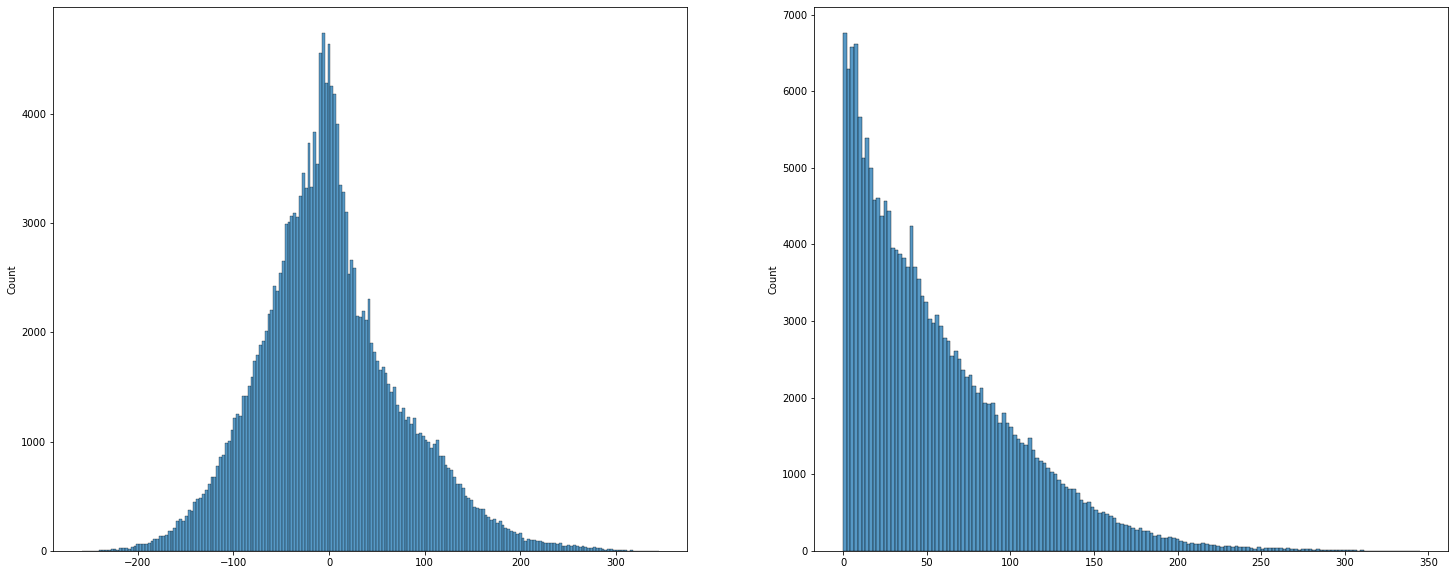

In [91]:
fig, ax = plt.subplots(1,2, figsize=(25, 10))
sns.histplot(errors, ax=ax[0])
sns.histplot(np.abs(errors), ax=ax[1])

In [92]:
s.stdev(errors)

73.45104611860287

In [93]:
np.percentile(errors, 5), np.percentile(errors, 95)

(-112.63637681942514, 133.18916266357675)

In [94]:
abserrors = np.abs(errors)
np.percentile(abserrors, 5), np.percentile(abserrors, 95)

(3.2063558877247034, 148.92826696254505)

In [95]:
np.median(abserrors), np.mean(abserrors)

(43.483033203801085, 55.857859568709216)

In [106]:
import json
with open("features_ds2.json", "w") as f:
    f.write(json.dumps(imp_scores))

In [108]:
import pickle
with open("features_ds2.sav", "wb") as f:
    pickle.dump(imp_scores, f)

In [111]:
import pickle
with open("features_ds2.sav", "rb") as f:
    imp_scores = pickle.load(f)

In [129]:
df = pd.DataFrame(imp_scores["model2"]["most_imp_feat"])
df["mean"] = df.apply(np.mean, axis=1)
df.sort_values(by="mean", ascending=False).head(50).reset_index()

,index,0,1,2,3,4,5,6,7,8,...,91,92,93,94,95,96,97,98,99,mean
0,MACCS_key99,0.203350,0.263514,0.133767,0.148118,0.259004,0.182429,0.358578,0.202660,0.207568,...,0.159364,0.147887,0.126998,0.179063,0.075098,0.265973,0.343522,0.087973,0.117339,0.221575
1,TPSA,0.044840,0.004457,0.016052,0.031738,0.000000,0.027248,0.039378,0.105808,0.035515,...,0.000000,0.011538,0.074399,0.057565,0.101700,0.000000,0.052625,0.010462,0.078729,0.052728
2,VSA_EState2,0.028163,0.065319,0.000000,0.048518,0.026680,0.037292,0.034280,0.040440,0.060039,...,0.019330,0.031514,0.000000,0.027335,0.048474,0.045550,0.037795,0.018919,0.042155,0.041871
3,MorganFP_bit_960,0.019975,0.023805,0.051620,0.037675,0.029851,0.005960,0.025928,0.000000,0.013022,...,0.000000,0.036929,0.038013,0.019274,0.049184,0.057393,0.026503,0.022827,0.018139,0.023609
4,BCUT2D_MRHI,0.025491,0.010044,0.019149,0.029831,0.030662,0.013914,0.016118,0.000000,0.021550,...,0.012996,0.022641,0.019570,0.013515,0.000000,0.018001,0.016449,0.026728,0.018943,0.017910
5,qed,0.049683,0.000000,0.004930,0.012795,0.005830,0.025907,0.026329,0.000000,0.008694,...,0.000000,0.029860,0.076836,0.000000,0.033377,0.000000,0.000000,0.014710,0.008914,0.013965
6,NumAromaticHeterocycles,0.008313,0.007955,0.006174,0.005827,0.004959,0.007469,0.000000,0.021057,0.011767,...,0.004037,0.000000,0.022914,0.010466,0.047621,0.049500,0.000000,0.007815,0.007137,0.010750
7,SlogP_VSA10,0.039083,0.004373,0.009802,0.000000,0.035163,0.015095,0.059699,0.000000,0.026879,...,0.019359,0.009845,0.000000,0.000000,0.000000,0.018305,0.013075,0.000000,0.053124,0.010154
8,MaxAbsEStateIndex,0.010929,0.029058,0.014552,0.016872,0.062924,0.042590,0.000000,0.000000,0.017243,...,0.053819,0.000000,0.027831,0.000000,0.002814,0.000000,0.000000,0.000000,0.025865,0.009875
9,MACCS_key75,0.000000,0.007596,0.005250,0.004266,0.004075,0.001787,0.004156,0.028357,0.022561,...,0.013089,0.023376,0.046371,0.000000,0.002117,0.000000,0.000000,0.019311,0.010421,0.008373


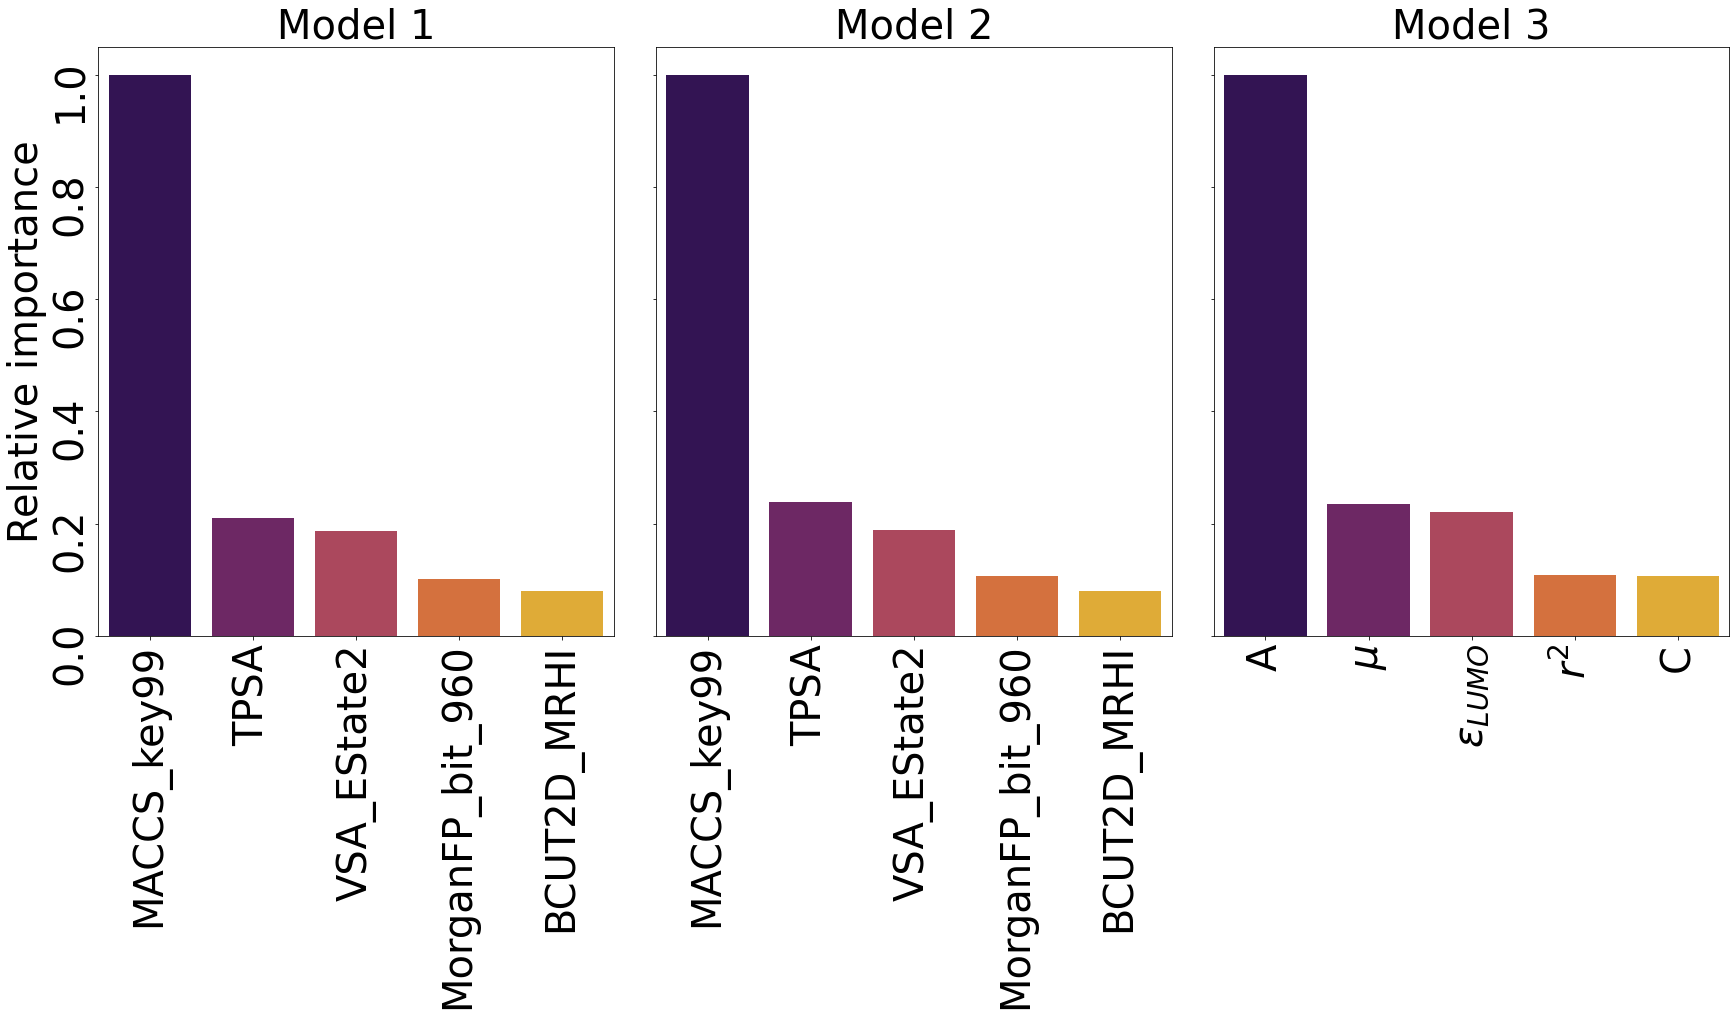

In [112]:
fig, ax = plt.subplots(1, 3, figsize=(25,15), sharey=True)
model_num = [f"Model {i+1}" for i in range(3)]
for i, k in enumerate(imp_scores.keys()):
    df = pd.DataFrame(imp_scores[k]["most_imp_feat"])
    df["mean"] = df.apply(np.mean, axis=1)
    df = df.sort_values(by="mean", ascending=False).head(5)
    sns.barplot(x=df.index, y=df["mean"]/df["mean"][0], ax=ax[i], palette="inferno")
    ax[i].tick_params(labelsize=40, rotation=90)
    ax[i].set_ylabel("")
    ax[i].set_title(model_num[i], fontsize=40)
ax[0].set_ylabel("Relative importance", fontsize=40)  
ax[2].set_xticklabels(["A", r"$\mu$", r"$\epsilon_{LUMO}$", r"$r^2$", "C"])
plt.tight_layout()

In [113]:
fig.savefig("relative_importances.pdf")

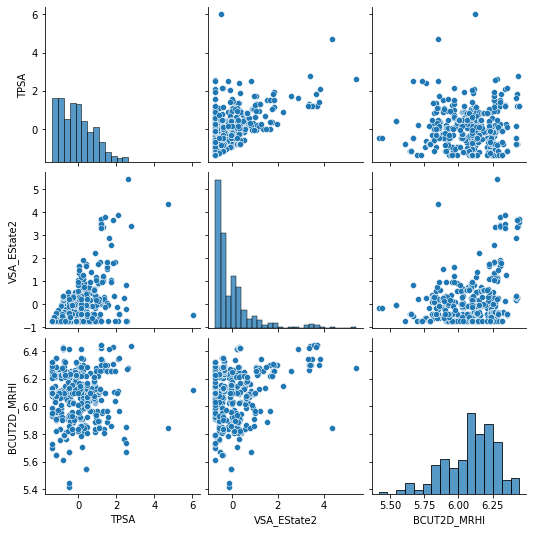

In [24]:
mif = "TPSA VSA_EState2 BCUT2D_MRHI MACCS_key99 MorganFP_bit_960"
mif = "TPSA VSA_EState2 BCUT2D_MRHI"
mif = mif.split()
sns.pairplot(only_solids[mif])

In [17]:
def get_features(row, database: pd.DataFrame, features: Union[List[str], str]) -> None:
    for index in row["qm9_pattern_indexes"]:
        count = find_pattern_count(row["RDKit_Mol_Class"], database["RDKit_Mol_Class"][index])
        for feature in features:
            value = count*database[feature][index]
            row[feature] += value
    return row

In [18]:
features = all_quantum_features

In [19]:
only_solids[features] = 0

In [20]:
only_solids = only_solids.apply(get_features, database=qm9_database, features=features, axis=1)

In [33]:
from matplotlib import rcParams

In [35]:
rcParams.keys()

KeysView(RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.avconv_args': [],
          'animation.avconv_path': 'avconv',
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.html_args': [],
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
        

In [73]:
# rcParams["xtick.labelsize"] = "medium"
# rcParams["ytick.labelsize"] = "medium"
rcParams["font.size"] = 80
rcParams["xtick.labelsize"] = 10
rcParams["ytick.labelsize"] = 10

/home/bartlomiejf-sluzbowy/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


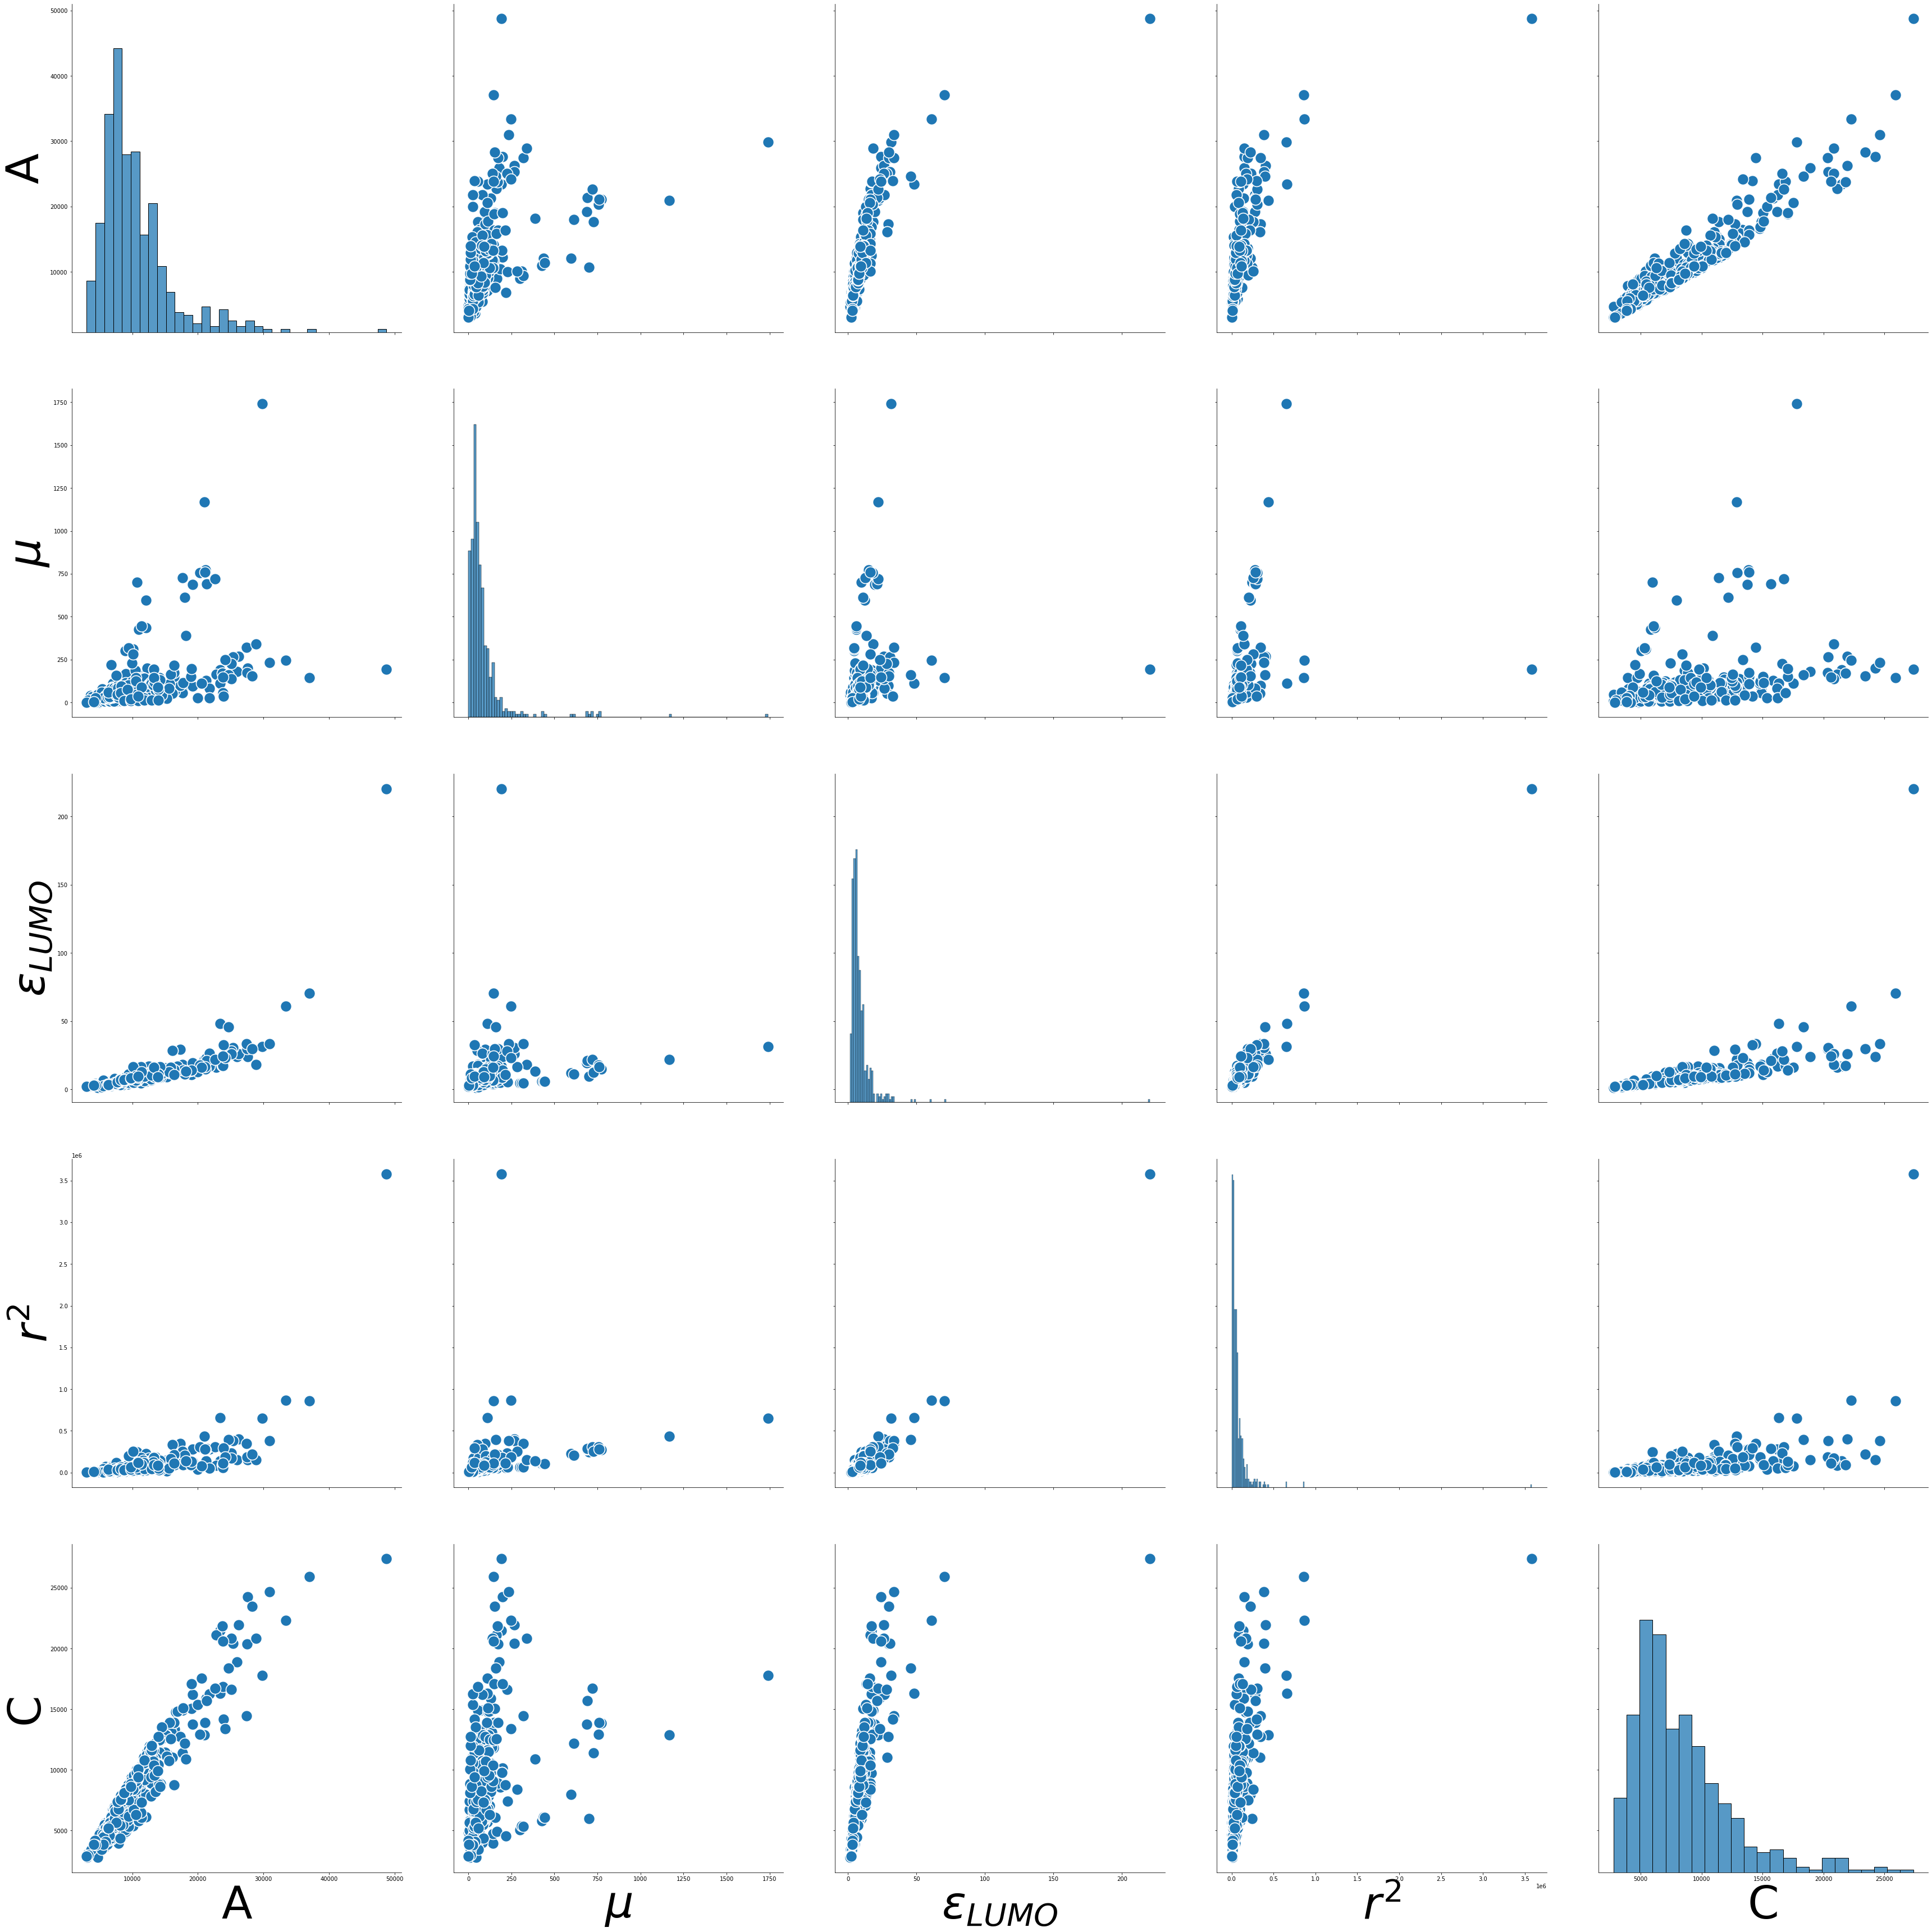

In [74]:
features = "A mu lumo r2 C"
features= features.split()
dat = only_solids[features].copy()
dat.columns = r"A $\mu$ $\epsilon_{LUMO}$ $r^2$ C".split()
fig = sns.pairplot(dat, size=10,
            plot_kws={"s": 400})
plt.tight_layout()

In [75]:
fig.savefig("pairplot2.pdf")

/home/bartlomiejf-sluzbowy/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


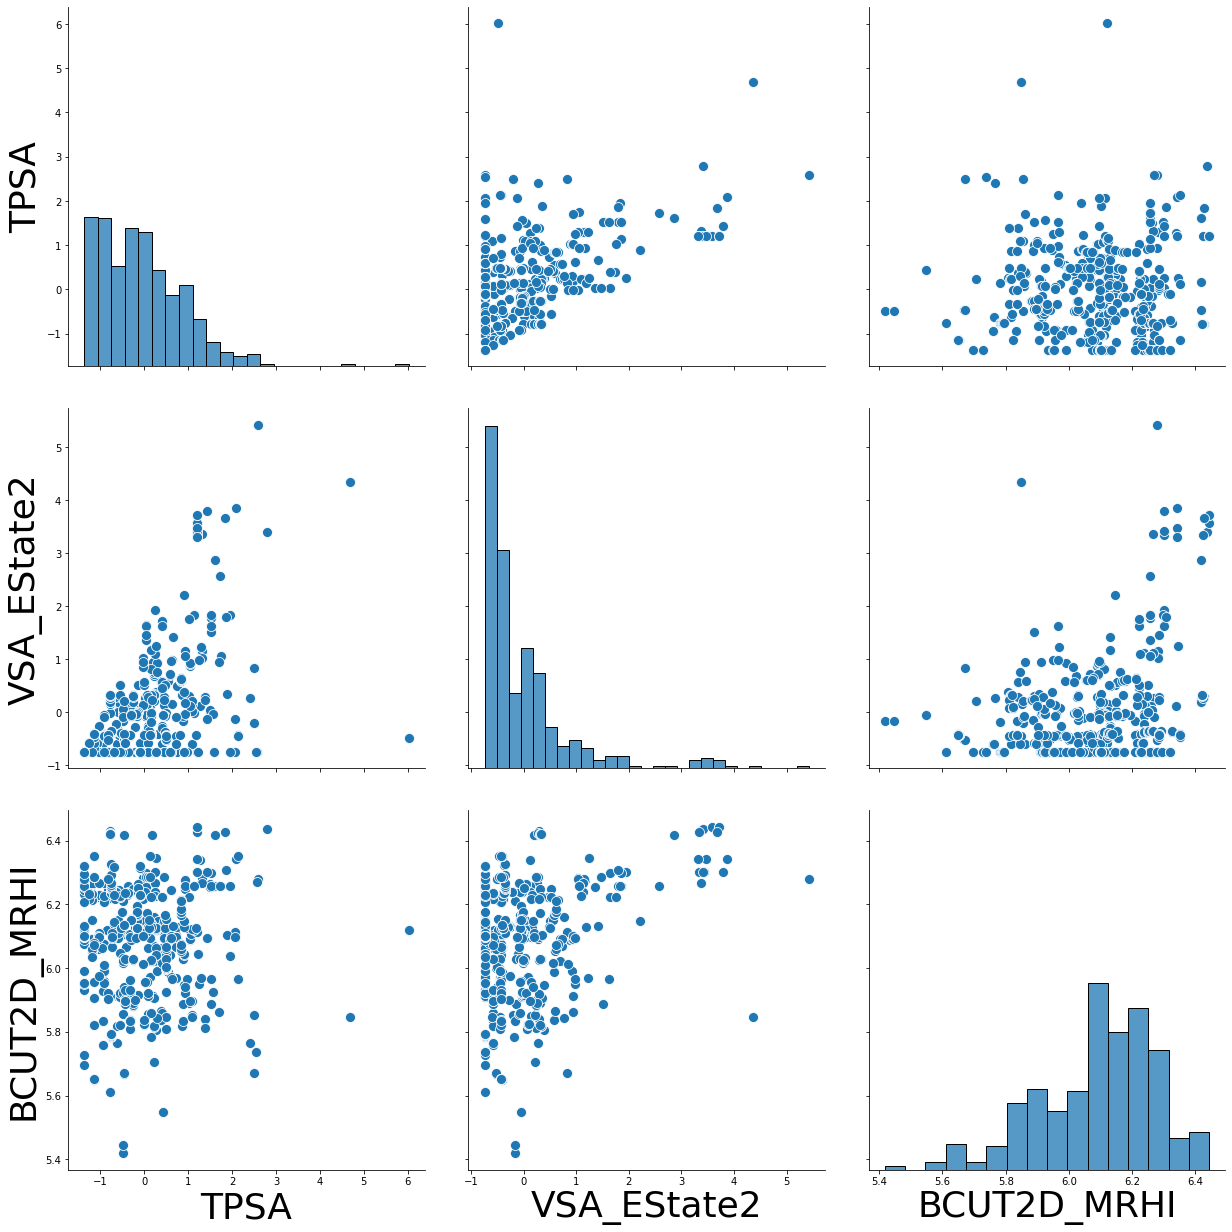

In [76]:
rcParams["font.size"] = 36
mif = "TPSA VSA_EState2 BCUT2D_MRHI MACCS_key99 MorganFP_bit_960"
mif = "TPSA VSA_EState2 BCUT2D_MRHI"
mif = mif.split()
fig = sns.pairplot(only_solids[mif], size=6,
                  plot_kws={"s": 100})
plt.tight_layout()

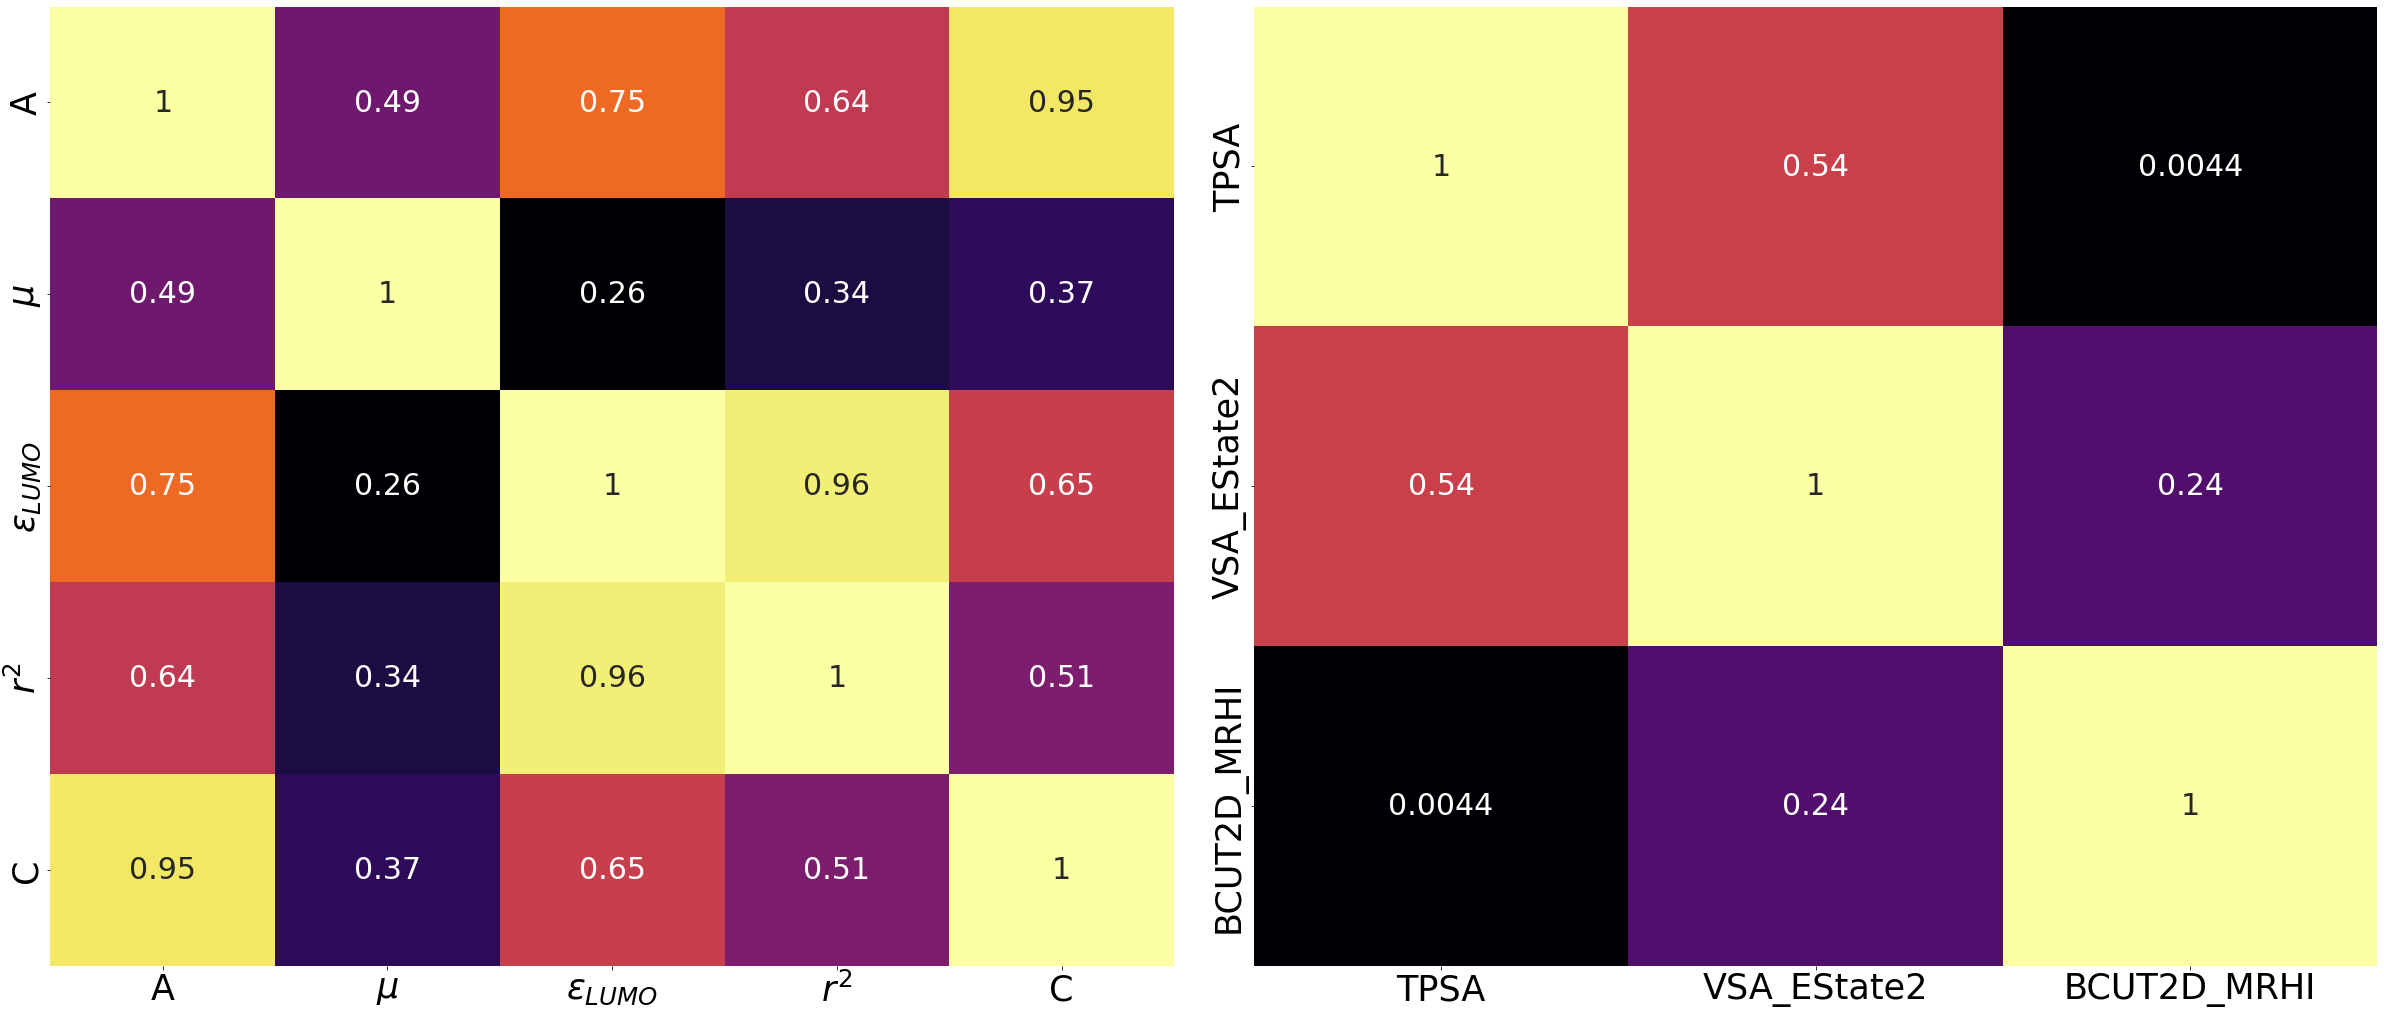

In [118]:
fig,ax = plt.subplots(1,2, figsize=(34,15))
features = "A mu lumo r2 C"
features= features.split()
dat = only_solids[features].copy()
dat.columns = r"A $\mu$ $\epsilon_{LUMO}$ $r^2$ C".split()
sns.heatmap(dat.corr(), ax=ax[0], cbar=False, annot=True, annot_kws={"fontsize": 30}, cmap="inferno")
ax[0].tick_params(labelsize=35)
mif = "TPSA VSA_EState2 BCUT2D_MRHI"
mif = mif.split()
dat = only_solids[mif]
sns.heatmap(dat.corr(), ax=ax[1], cbar=False, annot=True, annot_kws={"fontsize": 30}, cmap="inferno")
ax[1].tick_params(labelsize=35)
plt.tight_layout()

In [119]:
fig.savefig("corr_heatmaps.pdf")

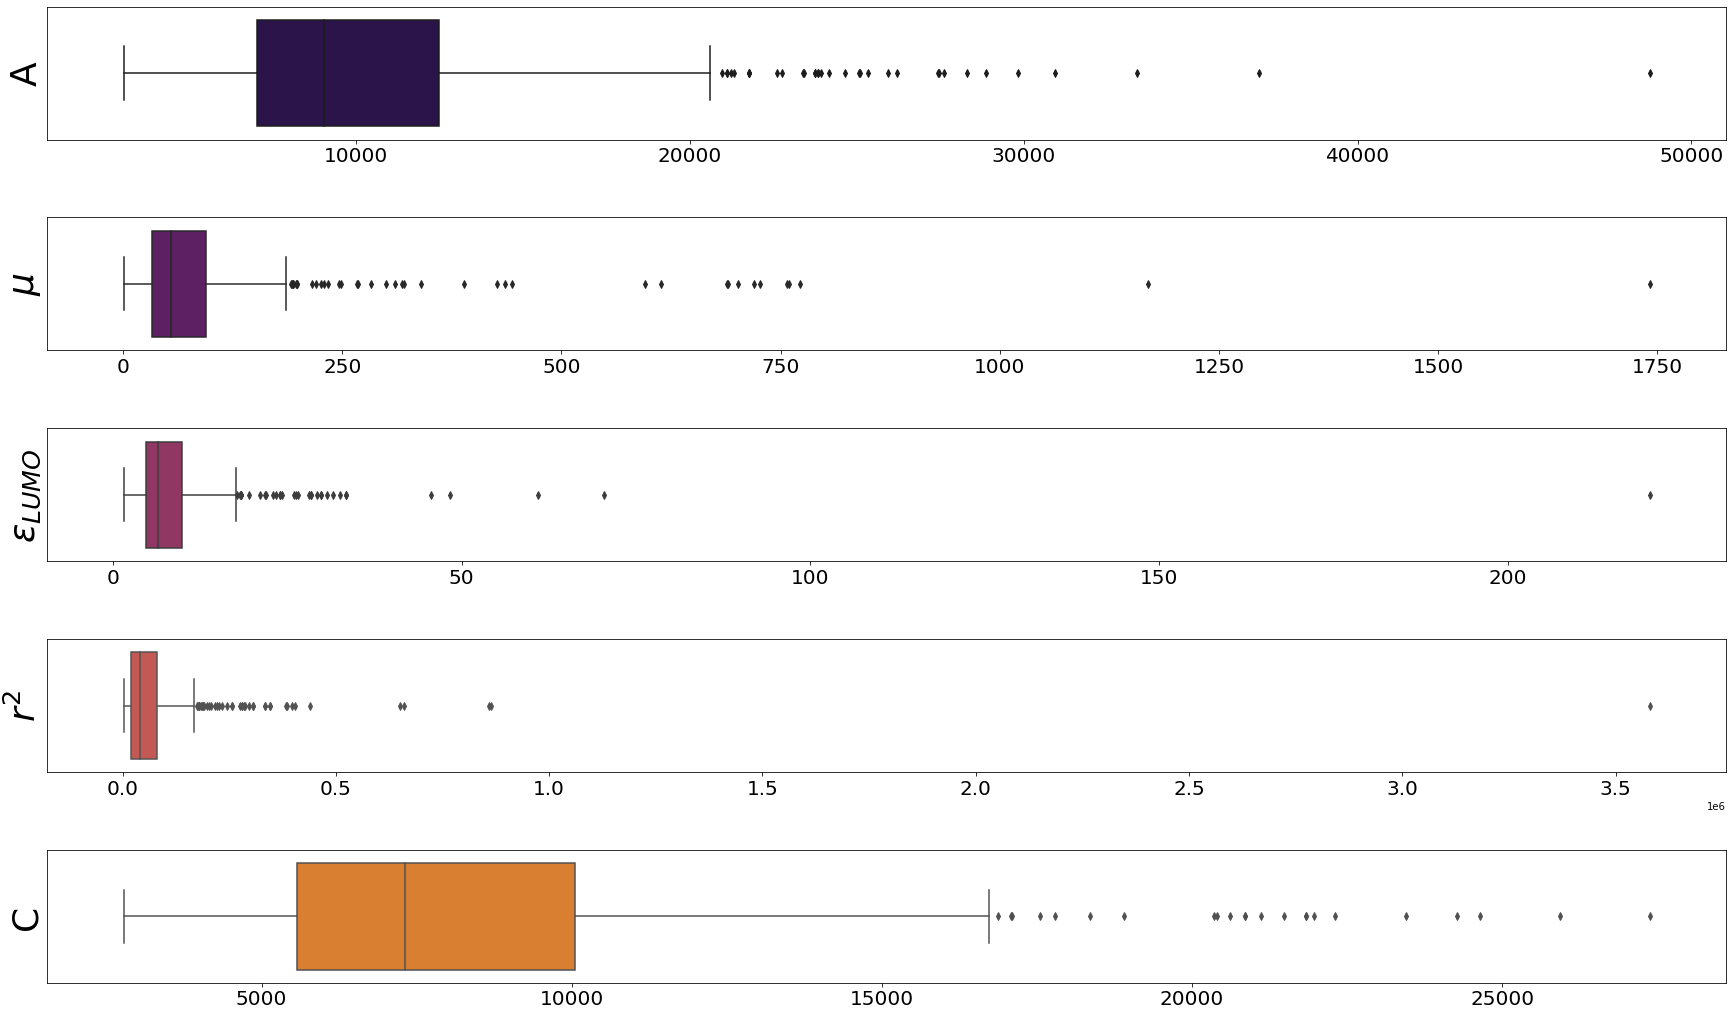

In [114]:
fig, ax = plt.subplots(5,1, figsize=(25,15))
features = "A mu lumo r2 C"
features= features.split()
for (i, feat), label in zip(enumerate(features), r"A $\mu$ $\epsilon_{LUMO}$ $r^2$ C".split()):
    sns.boxplot(data=only_solids[feat], orient="h", ax=ax[i], color=sns.color_palette("inferno")[i])
    ax[i].set_ylabel(label)
    ax[i].set_yticks([])
    ax[i].tick_params(labelsize=20)
plt.tight_layout()

In [115]:
fig.savefig("quant_feat_dist.pdf")